1. Collecting data from database

In [1]:
import os
import pandas as pd
df = pd.read_table('smsspamcollection/111.5.2.csv',
                   sep=',', 
                   header=None, 
                   names=['label', 'article'])
df.drop_duplicates(keep='first', inplace=True)
print(df)

      label                                            article
0     Right  https://fr.aleteia.org/2017/03/10/nous-chretie...
1     Right  https://fr.aleteia.org/2017/02/27/je-servais-l...
2     Right  https://fr.aleteia.org/2017/02/24/le-mot-de-la...
3     Right  https://fr.aleteia.org/2017/02/23/laurence-ros...
4     Right  https://fr.aleteia.org/2017/02/20/dimitri-casa...
...     ...                                                ...
2451   left  En République démocratique du Congo (RDC), la ...
2452   left  Après les députés il y a six jours, c'est au t...
2453   left  Le plus grand défi d’Angela Merkel reste la re...
2454   left  Le nouveau gouvernement burundais compte quinz...
2455   left  En raison du report du Tour de France, l'étape...

[2456 rows x 2 columns]


In [2]:
df['label'] = df.label.map({'left':0, 'Right':2,'Middle':1})
print(df.shape)
df.head() 
df['label'].isnull().value_counts

(2456, 2)


<bound method IndexOpsMixin.value_counts of 0       False
1       False
2       False
3       False
4       False
        ...  
2451    False
2452    False
2453    False
2454    False
2455    False
Name: label, Length: 2456, dtype: bool>

2. NLP preprocessing

In [3]:
import string
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
type(df)
stop = stopwords.words('french')
print(stop)
stemmer = SnowballStemmer("french")
def remove_punctuation(test):
    no_punct = "".join([c for c in test if c not in string.punctuation])
    return no_punct
def remove_url(test):
    remove = "".join(c.lower() for c in re.sub(r'[a-z]*[:.]+\S+', " ", test) )
    return remove
def remove_number(test):
    remove = "".join(c if c.isalpha() else ' ' for c in test)
    return remove
def word_stemmer(test):
    stem = "".join([stemmer.stem(i) for i in test] )
    return stem
df['text_split']=df['article'].apply(lambda x:' '.join([word for word in  nltk.RegexpTokenizer(pattern=r'\s+',gaps=True).tokenize(x) if word not in (stop)]))
df['text_url']=df['text_split'].apply(lambda x:remove_url(x))
df['text_clean']=df['text_url'].apply(lambda x:remove_number(x))
df['text_stem']=df['text_clean'].apply(lambda x:word_stemmer(x))

df['text_stem'].head()
#re.sub(r'\W|\b\w*\d\b', " ", test)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

0        nous  chrétiens  devons lancer sans délai ...
1        je servais lucifer sans savoir    livre ch...
2      le mot semaine     centrisme   friday      f...
3      laurence rossignol peut elle interdire mineu...
4      dimitri casali     est ce vraiment moment di...
Name: text_stem, dtype: object

3. Deep learning part(CNN) to do classification

In [6]:
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Flatten, LSTM
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split

In [7]:
counter = collections.Counter()
maxlen = 0
for words in df['text_stem']:
    words = [x.lower() for x in nltk.word_tokenize(words)]
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:    
        counter[word] += 1
print(maxlen)
print(counter)

2813
Counter({'l': 29706, 'd': 19858, 'a': 15371, 'est': 7365, 'il': 7361, 'plus': 6444, 'qu': 5990, 'le': 5632, 'n': 5438, 's': 4830, 'c': 4567, 'un': 4526, 'la': 4363, 'une': 4105, 'cette': 3846, 'les': 3591, 'aussi': 2877, 'comme': 2794, 'en': 2757, 'on': 2591, 'être': 2550, 'france': 2474, 'fait': 2462, 'pays': 2268, 'tout': 2266, 'deux': 2112, 'après': 2090, 'juin': 1936, 'depuis': 1934, 'si': 1898, 'faire': 1897, 'mais': 1836, 'contre': 1826, 'très': 1797, 'elle': 1781, 'président': 1776, 'monde': 1715, 'ce': 1708, 'ans': 1706, 'tous': 1694, 'entre': 1678, 'où': 1584, 'ils': 1527, 'sans': 1524, 'bien': 1514, 'et': 1479, 'autres': 1475, 'avoir': 1439, 'j': 1430, 'peut': 1430, 'à': 1417, 'je': 1406, 'nous': 1383, 'premier': 1381, 'politique': 1362, 't': 1354, 'pour': 1337, 'alors': 1316, 'selon': 1302, 'dont': 1299, 'gouvernement': 1266, 'encore': 1243, 'ministre': 1225, 'personnes': 1216, 'cas': 1210, 'avant': 1191, 'leurs': 1179, 'mois': 1134, 'dans': 1130, 'coronavirus': 1102, '

In [8]:
VOCAB_SIZE = 5000
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}
print(len(word2index))

5000


In [9]:
from keras.preprocessing import sequence
xs, ys = [], []
for x in df['label']:
    ys.append(x)
for words in df['text_stem']:
    words = [x.lower() for x in nltk.word_tokenize(words)]
    wids = [word2index[word] for word in words]
    xs.append(wids)
X = sequence.pad_sequences(xs, maxlen=maxlen)
Y = np_utils.to_categorical(ys,num_classes=3)

In [10]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=42)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
print(Ytrain)

(1719, 2813) (737, 2813) (1719, 3) (737, 3)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [31]:
sequence_length = X.shape[1] 
vocabulary_size = vocab_sz 
embedding_dim = 1000
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5
epochs = 3
batch_size = 30

In [32]:
# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

Creating Model...


In [33]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("Traning Model...")
model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(Xtest, Ytest))  # starts training

Traning Model...
Epoch 1/3
58/58 [==============================] - 1058s 18s/step - loss: 0.6227 - accuracy: 0.4241 - val_loss: 0.5686 - val_accuracy: 0.5563
Epoch 2/3
58/58 [==============================] - 1063s 18s/step - loss: 0.4913 - accuracy: 0.6638 - val_loss: 0.4879 - val_accuracy: 0.6703
Epoch 3/3
58/58 [==============================] - 1061s 18s/step - loss: 0.3827 - accuracy: 0.8138 - val_loss: 0.4305 - val_accuracy: 0.8277


4. Deep learning part(lstm)

In [171]:
EMBED_SIZE = 400
model = Sequential()
model.add(Embedding(output_dim=EMBED_SIZE, 
                    input_dim=vocab_sz,  
                    input_length=maxlen))
model.add(LSTM(50))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 2813, 400)         2000400   
_________________________________________________________________
lstm_37 (LSTM)               (None, 50)                90200     
_________________________________________________________________
dropout_68 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_69 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 3)                 303       
Total params: 2,096,003
Trainable params: 2,096,003
Non-trainable params: 0
___________________________________________

In [172]:
BATCH_SIZE =  64
NUM_EPOCHS = 10
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,epochs=NUM_EPOCHS,validation_data=(Xtest, Ytest)) 

Epoch 1/10
27/27 [==============================] - 74s 3s/step - loss: 1.0021 - accuracy: 0.4776 - val_loss: 0.8446 - val_accuracy: 0.5658
Epoch 2/10
27/27 [==============================] - 73s 3s/step - loss: 0.7351 - accuracy: 0.6539 - val_loss: 0.7346 - val_accuracy: 0.6418
Epoch 3/10
27/27 [==============================] - 82s 3s/step - loss: 0.4763 - accuracy: 0.8464 - val_loss: 0.6751 - val_accuracy: 0.6893
Epoch 4/10
27/27 [==============================] - 79s 3s/step - loss: 0.1710 - accuracy: 0.9517 - val_loss: 0.8365 - val_accuracy: 0.6920
Epoch 5/10
27/27 [==============================] - 75s 3s/step - loss: 0.0293 - accuracy: 0.9959 - val_loss: 0.9739 - val_accuracy: 0.7001
Epoch 6/10
27/27 [==============================] - 76s 3s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 1.1719 - val_accuracy: 0.6974
Epoch 7/10
27/27 [==============================] - 75s 3s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.2720 - val_accuracy: 0.6866
Epoch 8/10
27/27 [==

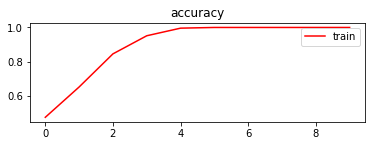

In [173]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
#plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

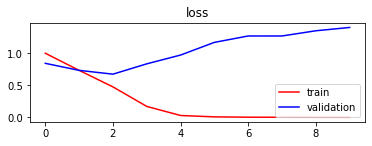

In [176]:
plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

In [175]:
score = model.evaluate(Xtest, Ytest, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

24/24 [==============================] - 10s 428ms/step - loss: 1.4052 - accuracy: 0.6906
Test score: 1.405, accuracy: 0.691


5. Tf-idf to do further preprocessing then using chi2 to select k best features

In [4]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
X=df['text_stem']
y=df['label']
vect=TfidfVectorizer(analyzer='word',encoding='latin-9')
vect.fit(X)
x1=vect.transform(X)
x=x1.toarray()
chi1 = SelectKBest(chi2, k=10000)    
X_train_chi2 = chi1.fit(x1,y)
X_new =X_train_chi2.transform(x1)
print(X_new.shape)

(2456, 10000)


6. Using chi2 to build dictionary

In [16]:
from sklearn.feature_selection import SelectKBest,chi2
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(x1, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(vect.get_feature_names())##vect.get_feature_names()
df_feature_scores = pd.concat([df_columns, df_scores], axis=1)
df_feature_scores.columns = ['Feature', 'Score']
a=df_feature_scores.sort_values(by='Score', ascending=False)
#df_feature_scores.to_csv('french dictionary.csv')
b=df_feature_scores.loc[df_feature_scores['Score']>=7.81]
#print(a)
print(b)
b.to_csv('french dictionary2.csv')

           Feature      Score
137        abonnés  28.823665
3156       article  26.058821
3893       authors   9.503851
6424       burundi   8.528389
8167     chrétiens  10.811144
8961           com  14.382748
10604  coronavirus  11.168056
12088     deutsche  14.159863
13385           dw  18.340023
16693     euronews  10.569750
16707   européenne  11.253813
18757   franceinfo  27.421951
20098          gpa   8.588827
24746           jt  43.209129
26327         lire  28.562770
27435        manif  13.468322
32149     pandémie  11.819345
32207         pape  12.039609
39846      réservé  16.902337
39847     réservée  15.260135
43057       sujets  14.282549
44342         text   9.503851
44650        title   9.503851
45883           ue  10.735146
45939          ump   9.215829
46286        valls   9.007119
47553        welle  15.382700
47754          www  14.831390


7. Using gridsearch to find optimal params, then do the claasification by different machine learning methods( LinearSVC,MultinomialNB,LogisticRegression) using voting strategy to find optimal method.

In [30]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 20, 50, 80, 100]},
                    {'kernel': ['linear'], 'C': [1, 20, 50, 80, 100]}]
scores = ['precision', 'recall']
for score in scores:
    print(" for %s" % score)
    clf = GridSearchCV(SVC(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score)
    clf.fit(X_new, y)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print(clf.best_score_)

 for precision


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters set found on development set:
{'C': 1, 'kernel': 'linear'}
0.8659555301379406
 for recall
Best parameters set found on development set:
{'C': 1, 'kernel': 'linear'}
0.8635824370926052


In [31]:
from sklearn.svm import LinearSVC
tuned_parameters = {'C':[1], 'penalty': ['l1', 'l2']}
scores = ['precision', 'recall']
for score in scores:
    print(" for %s" % score)
    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score)
    clf.fit(X_new, y)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print(clf.best_score_)

 for precision


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)


Best parameters set found on development set:
{'C': 1, 'penalty': 'l2'}
0.8753947910974322
 for recall


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)


Best parameters set found on development set:
{'C': 1, 'penalty': 'l2'}
0.8730541794735865


In [32]:
clf =svm.LinearSVC(C=1, penalty='l2')
scores = cross_val_score(clf, X_new, y, cv=10)
print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores1 = cross_val_score(clf,X_new, y, cv=10, scoring='f1_macro')
print("F1: %0.5f (+/- %0.2f) "% (scores1.mean(), scores.std() * 2))
scores2 = cross_val_score(clf,X_new, y, cv=10, scoring='recall_macro')
print("recall: %0.5f (+/- %0.2f) "% (scores2.mean(), scores.std() * 2))
scores3 = cross_val_score(clf,X_new, y, cv=10, scoring='precision_macro')
print("precision: %0.5f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

Accuracy: 0.87820 (+/- 0.09)
F1: 0.87291 (+/- 0.09) 
recall: 0.87305 (+/- 0.09) 
precision: 0.87539 (+/- 0.09)


In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
scores = ['precision', 'recall']
for score in scores:
    print(" for %s"%score)
    clf = GridSearchCV(MultinomialNB(), parameters, cv=10,
                       scoring='%s_macro' % score)
    clf.fit(X_new, y)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print(clf.best_score_)

 for precision
Best parameters set found on development set:
{'alpha': 0.001}
0.854285415916919
 for recall
Best parameters set found on development set:
{'alpha': 0.01}
0.8467751981691937


In [34]:
naive = MultinomialNB(alpha=0.001)
scores = cross_val_score(naive, X_new, y, cv=10)
print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores1 = cross_val_score(clf,X_new, y, cv=10, scoring='f1_macro')
print("F1: %0.5f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
scores2 = cross_val_score(clf,X_new, y, cv=10, scoring='recall_macro')
print("recall: %0.5f (+/- %0.2f) "% (scores2.mean(), scores2.std() * 2))
scores3 = cross_val_score(clf,X_new, y, cv=10, scoring='precision_macro')
print("precision: %0.5f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

Accuracy: 0.85212 (+/- 0.09)
F1: 0.84955 (+/- 0.10)
recall: 0.84812 (+/- 0.10) 
precision: 0.85427 (+/- 0.10)


In [35]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [ 0.01, 0.1, 1, 10, 50, 90], 'penalty':['l1','l2']}
scores = ['precision', 'recall']
for score in scores:
    print(" for %s" % score)
    cv = KFold(n_splits=10,shuffle=True)
    clf = GridSearchCV(LogisticRegression(), param_grid, cv=cv,
                       scoring='%s_macro' % score)
    
    clf.fit(X_new, y)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print(clf.best_score_)

 for precision


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.7/

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

Best parameters set found on development set:
{'C': 50, 'penalty': 'l2'}
0.8918466771500807
 for recall


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed

Best parameters set found on development set:
{'C': 10, 'penalty': 'l2'}
0.8851625121158031


In [36]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(C=50,penalty='l2')
scores = cross_val_score(lr, X_new, y, cv=10)
print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores1 = cross_val_score(lr,X_new, y, cv=10, scoring='f1_macro')
print("F1: %0.5f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
scores2 = cross_val_score(lr,X_new, y, cv=10, scoring='recall_macro')
print("recall: %0.5f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))
scores3 = cross_val_score(lr,X_new, y, cv=10, scoring='precision_macro')
print("precision: %0.5f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

Accuracy: 0.87699 (+/- 0.08)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

F1: 0.87154 (+/- 0.08)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

recall: 0.87162 (+/- 0.08)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

precision: 0.87364 (+/- 0.08)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
names = ["Logistic Regression", "Naive Bayes", "SVM Linear"]

classifiers = [LogisticRegression(C=50,penalty='l2'),MultinomialNB(alpha=0.001),LinearSVC(C=1, penalty='l2')
]
models = list(zip(names, classifiers))
clf = VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1 )
scores=cross_val_score(clf,X_new,y,cv=10)
print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.88106 (+/- 0.08)
